In [1]:
!pip install captum

     |████████████████████████████████| 1.3 MB 13.6 MB/s eta 0:00:01


In [9]:
import torch
import torch.nn as nn
import torchvision
from datasets.SSL4EO.ssl4eo_dataset_lmdb_mm import LMDBDataset,random_subset
from cvtorchvision import cvtransforms
import numpy as np
import matplotlib.pyplot as plt

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, LayerActivation, LayerAttribution

In [13]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, season='fixed'):
        self.base_transform = base_transform
        self.season = season

    def __call__(self, x):

        if self.season=='augment':
            season1 = np.random.choice([0,1,2,3])
            season2 = np.random.choice([0,1,2,3])
        elif self.season=='fixed':
            np.random.seed(42)
            season1 = np.random.choice([0,1,2,3])
            season2 = season1
        elif self.season=='random':
            season1 = np.random.choice([0,1,2,3])
            season2 = season1

        x1 = np.transpose(x[season1,:,:,:],(1,2,0))
        #x2 = np.transpose(x[season2,:,:,:],(1,2,0))

        q = self.base_transform(x1)
        #k = self.base_transform(x2)

        #return [q, k]
        return q

In [14]:
data1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'
data2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
season = 'fixed'

In [15]:
from models.rs_transforms_uint8 import RandomChannelDrop,RandomBrightness,RandomContrast,ToGray

train_transforms_s1 = cvtransforms.Compose([
    cvtransforms.CenterCrop(224),
    #cvtransforms.Resize(128),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(2)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_transforms_s2c = cvtransforms.Compose([
    cvtransforms.CenterCrop(224),
    #cvtransforms.Resize(128),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(13)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_dataset = LMDBDataset(
    lmdb_file_s1=data1,
    lmdb_file_s2=data2,
    s1_transform= TwoCropsTransform(train_transforms_s1,season=season),
    s2c_transform=TwoCropsTransform(train_transforms_s2c,season=season),
    is_slurm_job=True,
    normalize=False,
    dtype1='float32',
    dtype2='uint8',
    mode=['s1','s2c']
)   

In [16]:
class BarlowTwins_S1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        
        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))
        #sizes = [2048] + list(map(int, '8192-8192-8192'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)
        
        #self.bn = nn.BatchNorm1d(2048, affine=False)

    def forward(self, y1):
        z1 = self.projector1(self.backbone_1(y1))
        z1_c = z1[:,:448].mean(dim=-1,keepdim=True)
        z1_u = z1[:,448:].mean(dim=-1,keepdim=True)
        
        #z1 = self.backbone_1(y1)
        #z1_c = z1[:,:1792].mean(dim=-1,keepdim=True)
        #z1_u = z1[:,1792:].mean(dim=-1,keepdim=True)
        
        out = torch.cat((z1_c,z1_u),-1)
        
        return out

class BarlowTwins_S2(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        
        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))
        #sizes = [2048] + list(map(int, '8192-8192-8192'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)
        
        #self.bn = nn.BatchNorm1d(2048, affine=False)

    def forward(self, y2):
        z2 = self.projector2(self.backbone_2(y2))        
        z2_c = z2[:,:448].mean(dim=-1,keepdim=True)
        z2_u = z2[:,448:].mean(dim=-1,keepdim=True)
        
        #z2 = self.backbone_2(y2)     
        #z2_c = z2[:,:1792].mean(dim=-1,keepdim=True)
        #z2_u = z2[:,1792:].mean(dim=-1,keepdim=True)        
        
        out = torch.cat((z2_c,z2_u),-1)

        return out

In [17]:
resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50_prj8192/checkpoint_0061.pth'

#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/feature/B2B13_bt_mm2_decu_rn50/checkpoint_0052.pth'

model1 = BarlowTwins_S1()
model2 = BarlowTwins_S2()
ckpt = torch.load(resume, map_location='cpu')
state_dict = ckpt['model']
state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}
model1.load_state_dict(state_dict)
model2.load_state_dict(state_dict)


<All keys matched successfully>

In [18]:
model1.eval()
model2.eval()
layer_gc_1 = LayerGradCam(model1, model1.backbone_1.layer4[1].conv2)
layer_act_1 = LayerActivation(model1, model1.backbone_1.layer4[1].conv2)

layer_gc_2 = LayerGradCam(model2, model2.backbone_2.layer4[1].conv2)
layer_act_2 = LayerActivation(model2, model2.backbone_2.layer4[1].conv2)

In [19]:
def normalize(data):
    p2,p98 = np.percentile(data,(2,98))
    data = np.clip(data,p2,p98)
    data = (data - data.min()) / (data.max()-data.min())
    return data

def get_rgb(data):
    r = normalize(data[3])
    g = normalize(data[2])
    b = normalize(data[1])
    rgb = np.stack((r,g,b),-1)
    return rgb

def get_sar(data):

    return normalize(data[0])

(-0.5, 223.5, 223.5, -0.5)

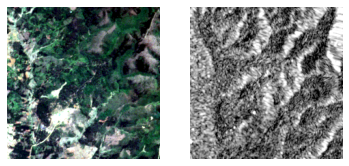

In [103]:
## visualize
id = 0
img_sar = train_dataset[id][0]
img_ms = train_dataset[id][1]

vis_ms = get_rgb(img_ms.cpu().numpy())
vis_sar = get_sar(img_sar.cpu().numpy())

plt.subplot(1,2,1)
plt.imshow(vis_ms)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(vis_sar, cmap='gray')
plt.axis('off')


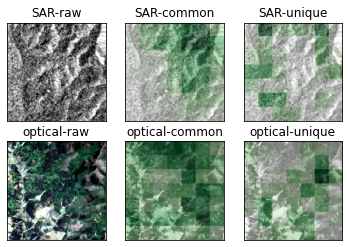

In [104]:
input1 = img_sar.unsqueeze(0)
ori_sar = get_sar(input1[0].cpu().numpy())
ori_sar = np.stack((ori_sar,ori_sar,ori_sar),-1)
attr_s1c = layer_gc_1.attribute(input1,target=0,relu_attributions=True)
upsampled_attr_s1c = LayerAttribution.interpolate(attr_s1c, (224, 224))

attr_s1u = layer_gc_1.attribute(input1,target=1,relu_attributions=True)
upsampled_attr_s1u = LayerAttribution.interpolate(attr_s1u, (224, 224))


input2 = img_ms.unsqueeze(0)
ori_rgb = get_rgb(input2[0].cpu().numpy())
attr_s2c = layer_gc_2.attribute(input2,0,relu_attributions=True)
upsampled_attr_s2c = LayerAttribution.interpolate(attr_s2c, (224, 224))

attr_s2u = layer_gc_2.attribute(input2,1,relu_attributions=True)
upsampled_attr_s2u = LayerAttribution.interpolate(attr_s2u, (224, 224))

#plt.figure(figsize=(6,4))
#plt.rcParams["font.size"] = "15"
fig, ax_array = plt.subplots(2, 3)
ax = ax_array.flat
# raw rgb
#plt.subplot(2,3,1)
viz.visualize_image_attr(
    upsampled_attr_s1c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_sar,
    sign="all",
    method="original_image",
    title="SAR-raw",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[0])
)

# common rgb
#plt.subplot(2,3,2)
viz.visualize_image_attr(
    upsampled_attr_s1c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_sar,
    sign="positive",
    method="blended_heat_map",
    title="SAR-common",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[1])
)

# unique rgb
#plt.subplot(2,3,3)
plt_s1_u = viz.visualize_image_attr(
    upsampled_attr_s1u[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_sar,
    sign="positive",
    method="blended_heat_map",
    title="SAR-unique",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[2]))
# raw dem
#plt.subplot(2,3,4)
plt_s2_raw = viz.visualize_image_attr(
    upsampled_attr_s2c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_rgb,
    sign="all",
    method="original_image",
    title="optical-raw",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[3]))
# common dem
#plt.subplot(2,3,5)
plt_s2_c = viz.visualize_image_attr(
    upsampled_attr_s2c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_rgb,
    sign="positive",
    method="blended_heat_map",
    title="optical-common",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[4]))
# unique dem
#plt.subplot(2,3,6)
plt_s2_u = viz.visualize_image_attr(
    upsampled_attr_s2u[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_rgb,
    sign="positive",
    method="blended_heat_map",
    title="optical-unique",
    use_pyplot=False,
    plt_fig_axis=(fig, ax[5]))

plt.savefig('../../results/appendix/gradcam_BE_batch_{}.png'.format(id),transparent=True,bbox_inches="tight")

In [100]:
##### count statistics
from tqdm import tqdm
#import scipy

#subset = random_subset(train_dataset,frac=0.1)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False,
    num_workers=10, drop_last=False)

list_mul_c = []
list_mul_u = []
list_mul_c_norm = []
list_mul_u_norm = []

for i,data in enumerate(tqdm(train_loader)):
    if i>98:
        break
    img_sar = data[0]
    img_ms = data[1]

    attr_s2_c = layer_gc_2.attribute(img_ms,target=0,relu_attributions=True)
    upsampled_attr_s2_c = LayerAttribution.interpolate(attr_s2_c, (224, 224))

    attr_s2_u = layer_gc_2.attribute(img_ms,target=1,relu_attributions=True)
    upsampled_attr_s2_u = LayerAttribution.interpolate(attr_s2_u, (224, 224)) 

    attr_s1_c = layer_gc_1.attribute(img_sar,target=0,relu_attributions=True)
    upsampled_attr_s1_c = LayerAttribution.interpolate(attr_s1_c, (224, 224))

    attr_s1_u = layer_gc_1.attribute(img_sar,target=1,relu_attributions=True)
    upsampled_attr_s1_u = LayerAttribution.interpolate(attr_s1_u, (224, 224))   

    ## cross correlation
    #corr_c =  scipy.signal.correlate2d(upsampled_attr_s2_c,upsampled_attr_s1_c).mean()
    #corr_u =  scipy.signal.correlate2d(upsampled_attr_s2_u,upsampled_attr_s1_u).mean()

    ## multiplication
    eps = 1e-20
    upsampled_attr_s2_c = torch.log10(upsampled_attr_s2_c+eps)
    upsampled_attr_s1_c = torch.log10(upsampled_attr_s1_c+eps)
    upsampled_attr_s2_u = torch.log10(upsampled_attr_s2_u+eps)
    upsampled_attr_s1_u = torch.log10(upsampled_attr_s1_u+eps)
    
    attr_s2_c_norm = (upsampled_attr_s2_c - upsampled_attr_s2_c.min()) / (upsampled_attr_s2_c.max()-upsampled_attr_s2_c.min())
    attr_s2_u_norm = (upsampled_attr_s2_u - upsampled_attr_s2_u.min()) / (upsampled_attr_s2_u.max()-upsampled_attr_s2_u.min())
    attr_s1_c_norm = (upsampled_attr_s1_c - upsampled_attr_s1_c.min()) / (upsampled_attr_s1_c.max()-upsampled_attr_s1_c.min())
    attr_s1_u_norm = (upsampled_attr_s1_u - upsampled_attr_s1_u.min()) / (upsampled_attr_s1_u.max()-upsampled_attr_s1_u.min())

    
    mul_c = (upsampled_attr_s2_c * upsampled_attr_s1_c).mean()
    mul_u = (upsampled_attr_s2_u * upsampled_attr_s1_u).mean()
    mul_c_norm = (attr_s2_c_norm * attr_s1_c_norm).mean()
    mul_u_norm = (attr_s2_u_norm * attr_s1_u_norm).mean()

    list_mul_c.append(mul_c.detach().numpy())
    list_mul_u.append(mul_u.detach().numpy())
    list_mul_c_norm.append(mul_c_norm.detach().numpy())
    list_mul_u_norm.append(mul_u_norm.detach().numpy())

np_mul_c = np.array(list_mul_c)
np_mul_u = np.array(list_mul_u)
np_mul_c_norm = np.array(list_mul_c_norm)
np_mul_u_norm = np.array(list_mul_u_norm)

#np.save('results/be_mul_c.npy',np_mul_c)
#np.save('results/be_mul_u.npy',np_mul_u)
#np.save('results/be_mul_c_norm.npy',np_mul_c_norm)
#np.save('results/be_mul_u_norm.npy',np_mul_u_norm)

print(np_mul_c.sum())
print(np_mul_u.sum())
print(np_mul_c_norm.sum())
print(np_mul_u_norm.sum())

  0%|          | 99/251079 [01:02<43:56:58,  1.59it/s]

13614.925
12737.642
nan
nan


In [1]:
import numpy as np
import matplotlib.pyplot as plt
#np_mul_c = np.load('results/be_mul_c.npy')
#np_mul_u = np.load('results/be_mul_u.npy')
#np_mul_c_norm = np.load('results/be_mul_c_norm.npy')
#np_mul_u_norm = np.load('results/be_mul_u_norm.npy')
np_mul_c = np.load('results/feature_be_mul_c.npy')
np_mul_u = np.load('results/feature_be_mul_u.npy')
np_mul_c_norm = np.load('results/feature_be_mul_c_norm.npy')
np_mul_u_norm = np.load('results/feature_be_mul_u_norm.npy')

/p/software/juwels/stages/2020/software/TensorFlow/2.3.1-gcccoremkl-9.3.0-2020.2.254-Python-3.8.5/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/p/software/juwels/stages/2020/software/TensorFlow/2.3.1-gcccoremkl-9.3.0-2020.2.254-Python-3.8.5/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


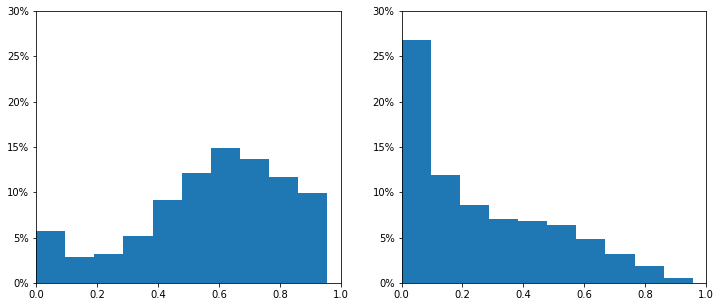

In [2]:
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np_mul_c_norm,weights=np.ones(len(np_mul_c_norm)) / len(np_mul_c_norm))
#plt.ylim((0,75000))
plt.xlim((0,1))
plt.ylim((0,0.3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
#plt.xticks(np.arange(0, 1, 0.2))
#plt.yticks(np.arange(0, 0.30, 3))
plt.subplot(1,2,2)
plt.hist(np_mul_u_norm,weights=np.ones(len(np_mul_u_norm)) / len(np_mul_u_norm))
#plt.ylim((0,75000))
plt.xlim((0,1))
plt.ylim((0,0.3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1,decimals=0))

In [ ]:
plt.figure(figsize=(6,4))
plt.rcParams["font.size"] = "15"
bins = np.linspace(0, 1, 10)
plt.hist(np_mul_c_norm,bins,weights=np.ones(len(np_mul_c_norm)) / len(np_mul_c_norm), alpha=0.5, label='common', color='r')
plt.hist(np_mul_u_norm,bins,weights=np.ones(len(np_mul_u_norm)) / len(np_mul_u_norm), alpha=0.5, label='unique', color='b')
plt.legend(loc='upper right')
plt.xlabel('overlap score')
plt.ylabel('percentage of data')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
#plt.savefig('results/gradcam_stats_BE.pdf',bbox_inches="tight")